## Calculate the fill factor for an LSST field of view.

Uses the camera geometry that is intended to represent the actual focal plane (or at least, one vendor's version of the focal plane geometry). 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

# For the footprint generation and conversion between galactic/equatorial coordinates.
from lsst.sims.utils import haversine, ObservationMetaData
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import chipNameFromPupilCoords

import lsst.sims.utils as sims_utils

mapper = LsstSimMapper()
camera = mapper.camera
epoch = 2000.0
site = sims_utils.Site()

In [8]:
# Set up pupil coordinate points to iterate over (to calculate fill factor)
testrange = 2.2
spacing = 0.01
xcen = 0
ycen = 0
xi = np.arange(xcen-np.radians(testrange), xcen+np.radians(testrange), np.radians(spacing))
yi = np.arange(ycen-np.radians(testrange), ycen+np.radians(testrange), np.radians(spacing))
x = []
y = []
for i in itertools.product(xi, yi):
    x.append(i[0])
    y.append(i[1])
x = np.array(x)
y = np.array(y)

In [3]:
# Calculate 'visibility'
chipNames = chipNameFromPupilCoords(x, y, camera=camera)
vis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        vis[i] = 1

In [4]:
# Confirm pupil coordinates are basically just the same as ra/dec offsets from boresight
import palpy 
ra = np.array([np.radians(1.75)])
dec = np.array([np.radians(1.75)])
xp, yp = palpy.ds2tpVector(ra, dec, 0, 0)
print ra, dec, xp, yp

[ 0.03054326] [ 0.03054326] [ 0.03055276] [ 0.03056702]


In [5]:
# Calculate % fill factor, for a particular assumed (circular) fov
area_degsq = 9.6
innerradius = np.sqrt(area_degsq/np.pi)
print 'inner radius matching area_degsq for circle', innerradius
sep = np.degrees(sims_utils.haversine(x, y, xcen, ycen))
print 'max distance from center used for chip calculation', sep.max()
incircle = np.where(sep < innerradius)[0]
onchip = np.where(vis[incircle] == 1)[0]
fillfactor = len(vis[onchip]) / float(len(vis[incircle]))
print 'fill factor', fillfactor

area_degsq = 9.6
innerradius2 = 1.75
print 'inner radius matching area_degsq for circle', innerradius2
sep = np.degrees(sims_utils.haversine(x, y, xcen, ycen))
print 'max distance from center used for chip calculation', sep.max()
incircle = np.where(sep < innerradius2)[0]
onchip = np.where(vis[incircle] == 1)[0]
fillfactor = len(vis[onchip]) / float(len(vis[incircle]))
print 'fill factor', fillfactor

outerradius = 2.06
print 'outer radius', outerradius
sep = np.degrees(sims_utils.haversine(x, y, xcen, ycen))
print 'max distance from center used for chip calculation', sep.max()
incircle = np.where(sep < outerradius)[0]
onchip = np.where(vis[incircle] == 1)[0]
fillfactor = len(vis[onchip]) / float(len(vis[incircle]))
print 'fill factor', fillfactor

inner radius matching area_degsq for circle 1.74807748895
max distance from center used for chip calculation 3.11088748063
fill factor 0.895371730367
inner radius matching area_degsq for circle 1.75
max distance from center used for chip calculation 3.11088748063
fill factor 0.895267496128
outer radius 2.06
max distance from center used for chip calculation 3.11088748063
fill factor 0.717074122139


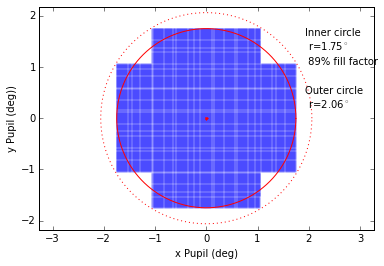

In [10]:
# Plot results.
plt.figure()
plt.axis('equal')
condition = np.where(vis == 1)[0]
#plt.plot(np.degrees(x), np.degrees(y), 'g.', markersize=0.2)
plt.plot(np.degrees(x[condition]), np.degrees(y[condition]), 'b.', markersize=0.3)
plt.plot(0, 0, 'r.')
plt.xlabel('x Pupil (deg)')
plt.ylabel('y Pupil (deg))')
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(innerradius*np.cos(theta)+np.degrees(xcen), innerradius*np.sin(theta)+np.degrees(ycen), 'r-')
plt.plot(outerradius*np.cos(theta)+np.degrees(xcen), outerradius*np.sin(theta)+np.degrees(ycen), 'r:')
#plt.xlim(fieldra+offset-sep.max()/2.0, fieldra+offset+sep.max()/2.0)
plt.ylim(np.degrees(xcen)-sep.max()*.7, np.degrees(ycen)+sep.max()*.7)
xco = 0.74
plt.figtext(xco, 0.8, 'Inner circle')
plt.figtext(xco, 0.75, r' r=1.75$^\circ$')
plt.figtext(xco, 0.7, ' 90%s fill factor' %('%'))
plt.figtext(xco, 0.6, 'Outer circle')
plt.figtext(xco, 0.55, r' r=2.06$^\circ$')
#plt.figtext(xco, 0.5, ' 71%s fill factor' %('%'))
plt.savefig('focalplane.png', format='png', dpi=600)

In [13]:
# And zoom in even more, to check raft/ccd spacing. 
testrange = 2.0
spacing = 0.00005
xi = np.arange(xcen - np.radians(testrange),
                xcen + np.radians(testrange), np.radians(spacing))
yi = np.zeros(len(xi)) + ycen

# Calculate 'visibility'
chipNames = chipNameFromPupilCoords(xi, yi, camera=camera)
vis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        vis[i] = 1

[ 798.3    43.92  798.66   46.08  799.02   50.04  799.38   43.92  799.74
   44.82  799.92   50.22  799.92   44.82  799.92   44.64  800.1    51.12
  799.92   44.1   799.56   44.46  799.38   49.68  799.02   45.36  798.66
   44.1   798.12]


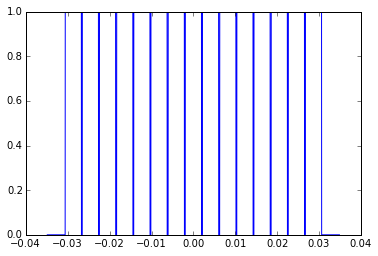

In [14]:
plt.plot(xi, vis)
condition = np.where(np.diff(vis) != 0)[0]
print np.diff(np.degrees(xi[condition])*60.*60.)

In [15]:
# And zoom in even more, to check raft/ccd spacing. 
testrange = 2.0
spacing = 0.00005
yi = np.arange(ycen - np.radians(testrange),
                ycen + np.radians(testrange), np.radians(spacing))
xi = np.zeros(len(yi)) + xcen

# Calculate 'visibility'
chipNames = chipNameFromPupilCoords(xi, yi, camera=camera)
vis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        vis[i] = 1

[ 812.52   30.42  813.06   30.24  813.42   34.74  813.78   31.86  813.96
   30.96  814.32   33.48  814.32   32.04  814.5    29.52  814.32   36.54
  814.32   30.78  814.14   28.8   813.78   37.26  813.42   29.52  813.06
   31.32  812.7 ]


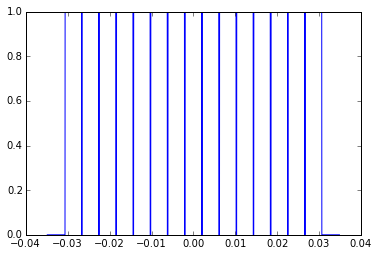

In [16]:
plt.plot(yi, vis)
condition = np.where(np.diff(vis) != 0)[0]
print np.diff(np.degrees(yi[condition])*60.*60.)